In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
with open('config.json') as config_file:
    config = json.load(config_file)

In [3]:
IN_SHAPE = config["image_shape"]
MAGNIFICATION = config["magnification"]
N_MAG = config["n_magnification"]
resolution = config["resolution"]/(MAGNIFICATION*N_MAG)
source_scaling = config["source_scaling"]

In [4]:
BATCH_SIZE = 5
dataset = data.LensingDataset('/home/anirudh/Documents/GSoC/LensSR/Simulations/data_model_1/',['no_sub_sie_noise'],5000)
hr_dataset = data.LensingDataset('/home/anirudh/Documents/GSoC/LensSR/Simulations/data_model_1/',['no_sub_sie_noise_HR'],5000)

In [5]:
i_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["i_depth"], in_channels=1, latent_channel_count=config["i_latent_channels"]).to(device)
s_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["s_depth"], in_channels=1, latent_channel_count=config["i_latent_channels"]).to(device)

alpha = torch.tensor([[config["alpha"] for _ in range(IN_SHAPE*MAGNIFICATION*N_MAG)] for __ in range(IN_SHAPE*MAGNIFICATION*N_MAG)]).to(device)
phy_loss = models.LensingLoss(in_shape=IN_SHAPE*MAGNIFICATION*N_MAG,device=device,alpha=alpha, resolution=resolution, BATCH_SIZE=BATCH_SIZE, source_scaling=source_scaling).to(device)
i_model.load_state_dict(torch.load('i_weight_sie_noise.pt'))
s_model.load_state_dict(torch.load('s_weight_sie_noise.pt'))

<All keys matched successfully>

In [6]:
def PSNR(mse): 
    """
    Computes the peak-signal to noise ratio

    :param mse: MSE to calculate from
    :return: PSNR value
    """ 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) 
    return psnr

from skimage.metrics import structural_similarity
history = {'loss':[],'SSIM':[], 'PSNR':[]}

def get_images(dataset, model1, length, i=None, plot=False):
    """
    To display a random image for illustration

    :param dataset: Dataset used
    :param model: Model used
    :param length: Length of dataset used
    :return: original LR image, SR image, original HR image
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i].view(1,1,IN_SHAPE,IN_SHAPE)
    HR = hr_dataset[i].view(1,1,IN_SHAPE*MAGNIFICATION,IN_SHAPE*MAGNIFICATION)
    image = model1(LR.float().to(device)).cpu().detach()
    return image[0][0], HR[0][0]

In [7]:
for i in tqdm.tqdm(range(len(dataset))):
    image, HR = get_images(dataset, i_model, len(dataset), i)
    loss = torch.nn.functional.mse_loss(image, HR)
    history['loss'].append(float(loss))
    image, HR = image.numpy(), HR.numpy()
    history['SSIM'].append(structural_similarity(image,
                                                 HR,data_range=1.0))
    history['PSNR'].append(PSNR(float(loss)))
print(f"Evaluation completed with \nMSE: {np.mean(history['loss'])} ({np.std(history['loss'])})\nSSIM: {np.mean(history['SSIM'])} ({np.std(history['SSIM'])})\nPSNR:  {np.mean(history['PSNR'])} ({np.std(history['PSNR'])})")

100%|██████████| 5000/5000 [00:27<00:00, 183.78it/s]

Evaluation completed with 
MSE: 0.004130962985521182 (0.0008128396511489788)
SSIM: 0.639440222689802 (0.06059367249649303)
PSNR:  23.917979799713777 (0.8159711734317621)


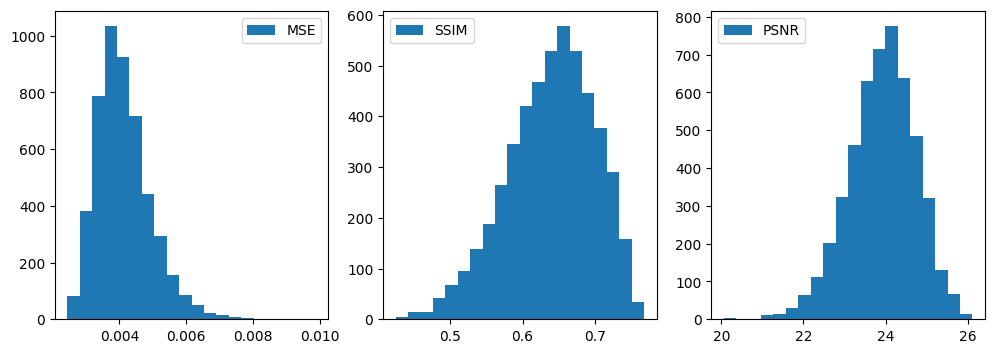

In [12]:
import matplotlib.pyplot as plt
plot, axes = plt.subplots(1,3)
plot.set_size_inches(12,4)
axes[0].hist(history['loss'],20,label='MSE')
axes[1].hist(history['SSIM'],20,label='SSIM')
axes[2].hist(history['PSNR'],20,label='PSNR')
axes[0].legend()
axes[1].legend()
axes[2].legend()

In [8]:
"""
SIS

100%|██████████| 5000/5000 [00:28<00:00, 176.33it/s]Evaluation completed with 
MSE: 0.006205329769244417 (0.0021702369226974665)
SSIM: 0.6398297842059227 (0.0561791079220963)
PSNR:  22.271652309471122 (1.2391140310636526)
"""

"""
SIS w noise

100%|██████████| 5000/5000 [00:25<00:00, 192.62it/s]Evaluation completed with 
MSE: 0.003995750087592751 (0.0008923668387240758)
SSIM: 0.6551615977904781 (0.06846530797572699)
PSNR:  24.081966545589314 (0.9053197811409819)
"""

"""
SIE with SIS lens

100%|██████████| 5000/5000 [00:30<00:00, 166.01it/s]
Evaluation completed with 
MSE: 0.0046506861953064796 (0.0012477830671723134)
SSIM: 0.5933275393505997 (0.047542952201963855)
PSNR:  23.46127849210275 (1.0589321804357954)
"""

"""
SIE

100%|██████████| 5000/5000 [00:25<00:00, 192.95it/s]
Evaluation completed with 
MSE: 0.004474920933879912 (0.0013816138672191989)
SSIM: 0.6137583619556546 (0.05351255738862998)
PSNR:  23.66090986287153 (1.160199189644181)
"""

"""
SIE w noise

100%|██████████| 5000/5000 [00:27<00:00, 183.78it/s]Evaluation completed with 
MSE: 0.004130962985521182 (0.0008128396511489788)
SSIM: 0.639440222689802 (0.06059367249649303)
PSNR:  23.917979799713777 (0.8159711734317621)
"""

'\nSIE\n\n100%|██████████| 5000/5000 [00:25<00:00, 192.95it/s]\nEvaluation completed with \nMSE: 0.004474920933879912 (0.0013816138672191989)\nSSIM: 0.6137583619556546 (0.05351255738862998)\nPSNR:  23.66090986287153 (1.160199189644181)\n'